In [1]:
#import modules
#%pylab inline 
#matplotlib notebook 
import os 
import nglview as nv
import numpy as np
#import mdtraj as mdt
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from matplotlib import rc
plt.rc('text', usetex=True)
import seaborn as sns
#plt.rc('font', family='serif')
import collections
from scipy.ndimage.filters import gaussian_filter
import pandas as pd

_ColormakerRegistry()

In [2]:
from scipy.signal import argrelextrema

In [3]:
plt.style.use('seaborn-poster')
sns.set_context("poster")
#print(plt.style.available)

In [4]:
Sim_Direc = !(ls -l | grep '^d'| awk '{print $9}')
bas_dir = !pwd
#Sim_Direc = !(ls -d */)

In [5]:
print(bas_dir[0])
print(Sim_Direc)
#colors taken from https://matplotlib.org/3.1.0/gallery/color/named_colors.html
col=['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
      'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

/media/john/ARCHIVOS/Trabajo_de_grado/SIMS_ALL_FEB/Test_new_order
['15STX-DMPG', '15STX-DPPG', '15STXrigid-DMPG', '15STXrigid-DPPG', 'MEM-DMPG', 'MEM-DPPG', 'STX-DMPG', 'STX-DPPG', 'STXrigid-DMPG', 'STXrigid-DPPG']


## Read & Sorting function:
It puts arranges in regular intervals, like 0.0, 1.1,.... If some two values are in the same interval, it averages these values and if there isn't a value in an interval it puts 0 value.

In [6]:
def sort(file,direc,sk_l1,sk_l2,dt):#=0.05):
#input of directories
    if("MEM" in direc):
        start=1;
        N=1
    else:
        start=1;
        N=5
    n=[]; m=[];
    t=np.zeros((N,8000)); x=np.zeros((N,8000,8000));
    pos_zeros=[]
    pos_zeros2=[[],[],[],[],[]]
    for replica in range(start,N+1):
        work_dir = ("{}/{}".format(direc,replica))
        data = np.genfromtxt("{}/{}/{}".format(bas_dir[0],work_dir,file),skip_header=sk_l1)
###############################
        n0=np.shape(data[:,1:])[0]
        m0=np.shape(data[:,1:])[1]
        m=np.append(m,m0)
        t0=data[0,0]#0.
        pos=0
        temp=0
        xtemp=np.zeros((1,m0))
        t[replica-1,0]=data[0,0]
        x[replica-1,0,:m0]=data[0,1:]
        #print("replica {}".format(replica))
        for i in range(1,n0):
            pos_ant=pos
            pos=int(np.round((data[i,0]-t0)/dt))
            #print(i,"\t",pos_ant,"\t",pos,data[i-1,0])
            if(pos_ant==pos):
                t[replica-1,pos]=(temp+data[i,0])/2
                x[replica-1,pos,:m0]=(xtemp+data[i,1:])/2
                #print(i,"\t",pos_ant,"\t",pos,data[i-1,0])
            else:
                t[replica-1,pos]=data[i,0]
                x[replica-1,pos,:m0]=data[i,1:]
                if(pos_ant+1<pos):
                    #print("k",i,"\t",pos_ant,"\t",pos)
                    #pos_zeros2[replica-1]=np.append(pos_zeros[replica-1],pos)
                    pos_zeros.append(pos-1)
                    pos_zeros2[replica-1].append(pos-1)
            #print(np.round((data[i-1,0]-t0)/dt)," ",data[i-1,0]," ",t[i-1,replica-1]," ",temp)
            #print(pos_ant,"\t",pos,"\t",t[replica-1,i]) #,"\t",data[i-1,1:])
            temp=data[i,0]#dato anterior
            xtemp=data[i,1:]#dato anterior
        n=np.append(n,pos)
        #print("fin replica", end="\n")
    n0=int(np.min(n))+1
    m0=int(np.min(m))+1
    x_f_tmp=[];t_f_tmp=[]; skip=np.array([])
    d = {x:pos_zeros.count(x) for x in pos_zeros}#set of  pos_zeros and its frequencies
    #print(list(d.keys()))
    #print(d.values())
    skip=list(list(d.keys()))#np.array(list(d.keys())).sort()
    skip.sort()
#    print("skipped:",skip)
#     if(len(skip)==0): #It's in the case we don't skip
#         skip.append((n0+1)*np.ones(n0))
    for i in range(n0):
#         if(i<len(skip)):
        cnt=0
        for j in range(len(skip)):
            if(i==skip[j]):#and(t[:,i].any()!=0):
                cnt+=1
        if(cnt==0):
            x_f_tmp.append(x[:,i,:m0])
            t_f_tmp.append(t[:,i]) 
#            print(i,"\t",t[:,i])
#         elif(i>=len(skip)):
#             x_f_tmp.append(x[:,i,:m0])
#             t_f_tmp.append(t[:,i])            
#            #print(np.shape(x[:,i,:m0]),"\t",t[:,i])
    x_final=[];t_final=[];
    for i in range(len(t_f_tmp)):
        t_final.append(list(t_f_tmp[i]))
    t_final=np.array(t_final)
    for i in range(len(x_f_tmp)):
        x_final.append(list(x_f_tmp[i]))
    x_final=np.array(x_final)
    #print(n,m)
    #print(n0,m0)
    #print(pos_zeros)
    print(np.shape(t_final),"\t",np.shape(x_final))
    #print(x_f_tmp)#,"\t",pos_zeros2)
    return t_final, x_final
    #print(t[:,:n0])#,"\t",pos_zeros2)
    #return t[:,:n0],x[:,:n0,:m0]

## Computation of phosphate positions using gromacs density

In [7]:
def phosphate(file,direc,sk_l1):#=0.05):
#         cnt=9
#         sk_l1=0
#         file="density/p_density.xvg"     
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in direc):
                z_com=3.96152
            elif("DPPG" in direc):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7
        z_tmp=[[],[]]
        for replica in range(start,N+1):
            work_dir = ("{}/{}/{}".format(bas_dir[0],direc,replica))
            data = np.genfromtxt("{}/{}".format(work_dir,file),skip_header=sk_l1)
#             print(np.shape(data[:,1]))
            maxInd = argrelextrema(data[:,1], np.greater)
            z_tmp[0].append(data[maxInd,0][0][0])
            z_tmp[1].append(data[maxInd,0][0][1])
#         r = data[maxInd,1]  
#         print(r,maxInd)
#         print(z_tmp[0])
#         print(z_tmp[1])
        return np.average(z_tmp[0]),np.average(z_tmp[1])

# Computation of stress profile along z axis.
* Crystalline, Ordered and Disordered Lipid Membranes: Convergence of Stress Profiles due to Ergosterol Juan M. Vanegas,

In [8]:
def pi(stress):
    pxx=-stress[:,:,0]
    pyy=-stress[:,:,4]
    pzz=-stress[:,:,8]
    return (pxx+pyy)/2-pzz

In [9]:
def av(x):
    pi_av=[]
    for i in range(len(x[:,0])):
        pi_av=np.append(pi_av,np.average(x[i,:]))
    np.shape(pi_av)
    return pi_av

# Plots

## Z_com of membrane

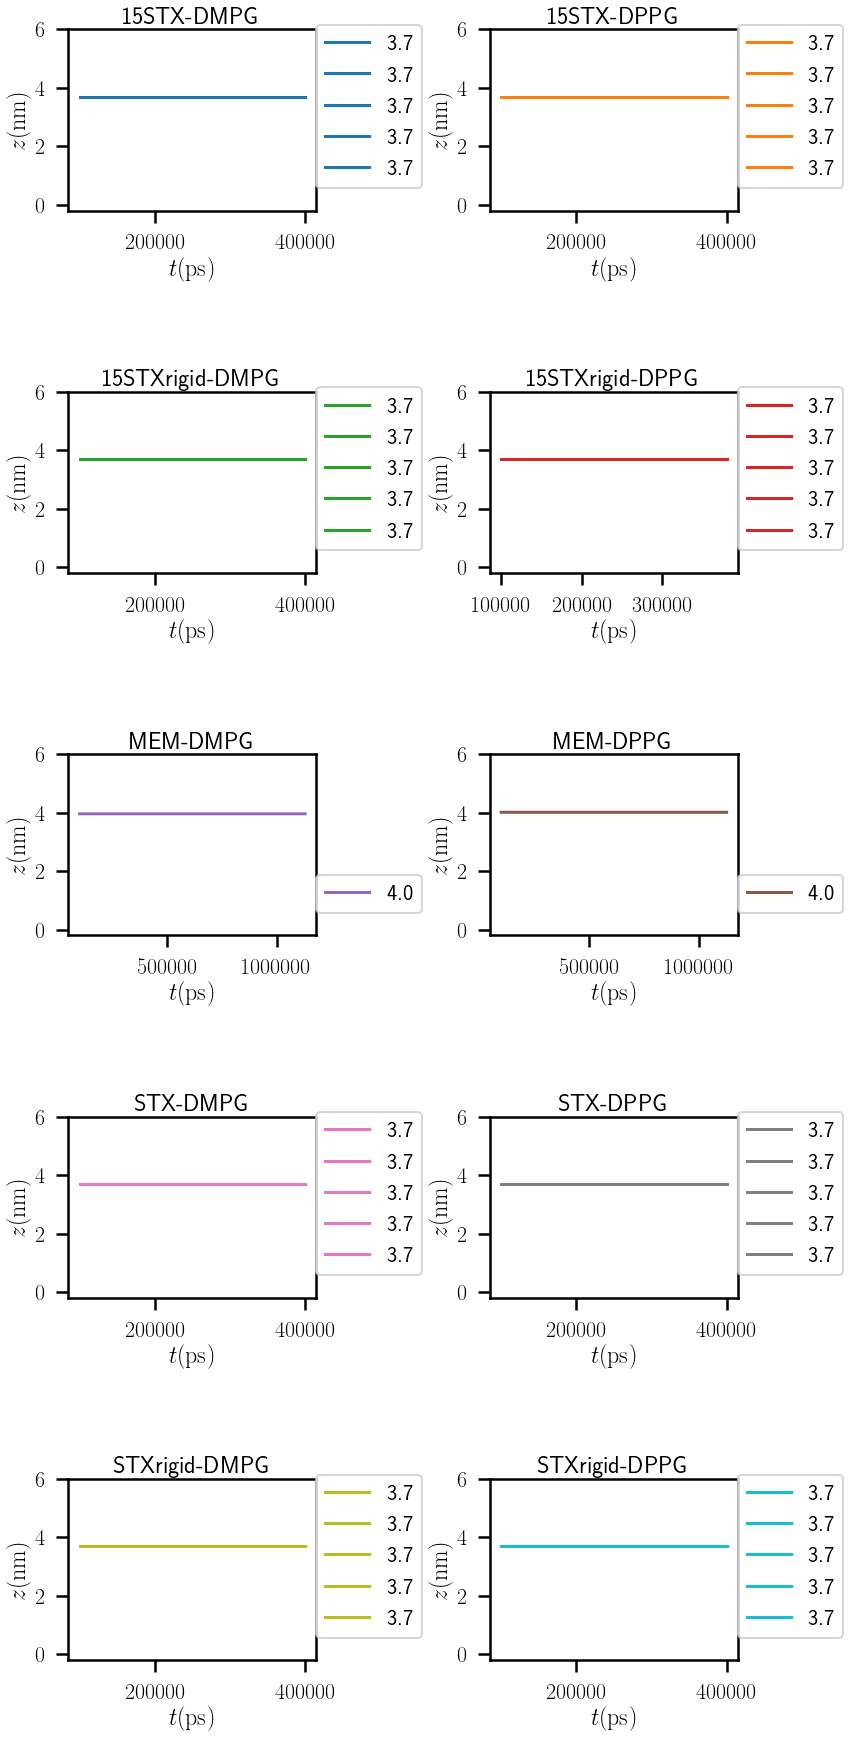

In [10]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=False,figsize=(12,30),gridspec_kw={'hspace': 1, 'wspace': 0.7})
com_memb=[]
for i in range(N):
    for j in range(M):
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
        else:
            start=1;
            N=5
        for replica in range(start,N+1):
            work_dir = ("{}/{}".format(Sim_Direc[cnt],replica))
            data = np.genfromtxt("{}/{}/{}".format(bas_dir[0],work_dir,"mdstress/z_memb.xvg"),skip_header=24)
            com_memb=np.append(com_memb,np.average(data[:,1]))
            ax[i][j].plot(data[:,0],data[:,1],color=col[cnt],label="{:.1f}".format(com_memb[-1]))
            #ax[i][j].axhline(np.average(data[:,1]))
            #ax[k][j].set_yticklabels([-1010,-1000,-500,0,500,1000,1010])#np.arange(-1200,1200,200))#, fontsize=12)
            ax[i][j].set_xlabel(r"$\displaystyle t(\mathrm{ps})$")
            ax[i][j].set_ylabel(r" $\displaystyle z(\mathrm{nm})$")
            ax[i][j].set_title("{}".format(Sim_Direc[cnt]))
            ax[i][j].set_ylim(-0.2,6)
        cnt+=1
        ax[i][j].legend(loc=(1,.5/4))
plt.savefig("../Plots/com_memb.png")

### Plots of z versus bin

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


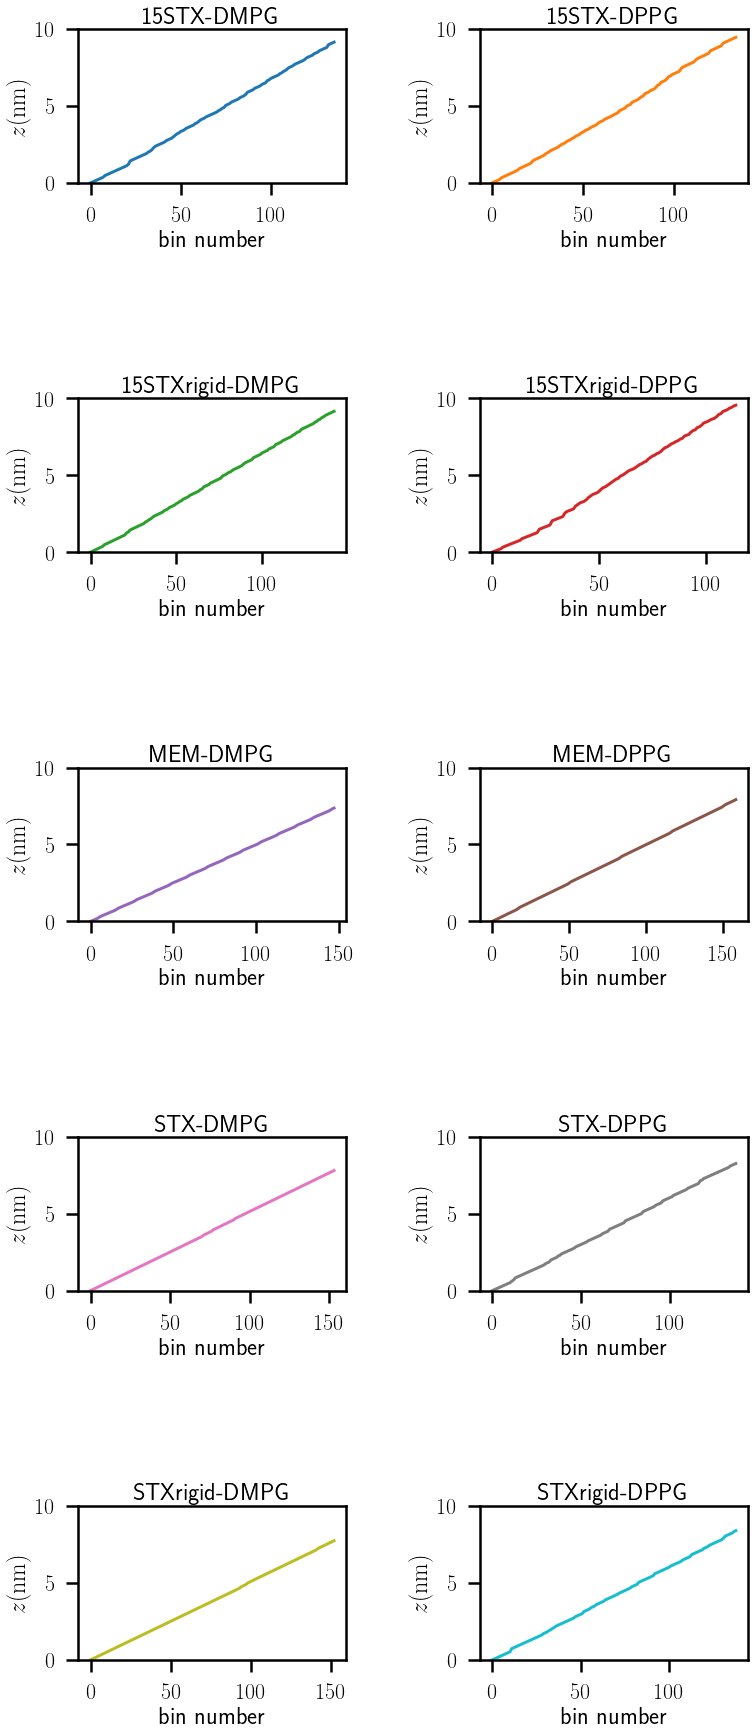

In [11]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=False,figsize=(12,30),gridspec_kw={'hspace': 1.4, 'wspace': 0.5})
for i in range(N):
    for j in range(M):
        z,stress=sort("mdstress/stress.txt",Sim_Direc[cnt],2,2,0.05)
            #ax[k][j].scatter(z,-stress[:,4],color=col[cnt])
        ax[i][j].plot(np.arange(len(av(z))),av(z),color=col[cnt])
            #ax[k][j].set_yticklabels([-1010,-1000,-500,0,500,1000,1010])#np.arange(-1200,1200,200))#, fontsize=12)
        ax[i][j].set_xlabel(r"bin number $\displaystyle$")
        ax[i][j].set_ylabel(r"$\displaystyle z(\mathrm{nm}) $")
        ax[i][j].set_title("{}".format(Sim_Direc[cnt]))
        ax[i][j].set_ylim(0,10)
        cnt+=1
plt.savefig("../Plots/z_bin.png")

## Example

(136, 5) 	 (136, 5, 10)


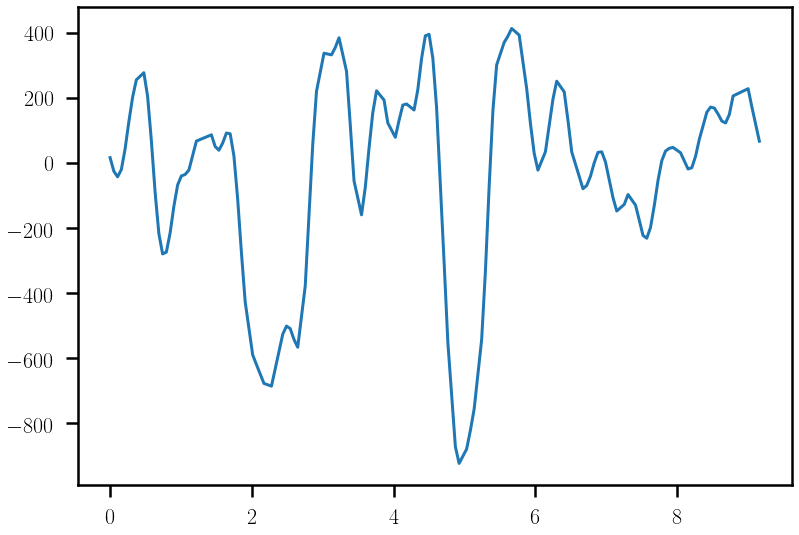

In [12]:
j=0
z,sigma=sort("mdstress/stress_2.txt",Sim_Direc[j],2,2,0.05)#stress,z=f("mdstress/stress.txt",Sim_Direc[4],2,2)
plt.plot(z[:,0],pi(sigma[:,:,:])[:,0])

In [13]:
pi_max=np.max(pi(sigma[:,:,:]))
print("Pi_max={}".format(pi_max))
pos=np.where(pi(sigma[:,:,:])==pi_max)
#print(b)
#print(pi(sigma[:,:,:])[b[0][0],b[1][0]])
print("z_0={}".format(z[pos[0][0],pos[1][0]]))
print(sigma[pos[0][0],pos[1][0],:])
print("Sigma={} ".format(-((sigma[pos[0][0],pos[1][0],0]+sigma[pos[0][0],pos[1][0],4])/2-sigma[pos[0][0],pos[1][0],8])))

Pi_max=755.1429915266266
z_0=4.277103659573599
[-143.21948439  -55.41502066  162.71660487  -55.41502066 -206.06339538
   73.46712155  162.71660487   73.46712155  580.50155165    0.        ]
Sigma=755.1429915266266 


In [14]:
#por replica
for i in range(5):#74):
    print(i,"\t",sigma[0,i,:],"\t",z[0,i]) #stress size

0 	 [  79.75372228 -265.10964879  102.96017948 -265.10964879  222.64611178
   37.14948605  102.96017948   37.14948605  168.35622392    0.        ] 	 0.0
1 	 [ 164.23471901 -192.14264517   90.82570001 -192.14264517  -17.40720472
  209.86514566   90.82570001  209.86514566  125.87223248    0.        ] 	 0.0
2 	 [194.71510281  28.33678535 -78.88864442  28.33678535  60.58912978
 -11.32515348 -78.88864442 -11.32515348  -5.56822124   0.        ] 	 0.0
3 	 [ 348.63732576  251.47863702 -118.48092804  251.47863702   60.42089125
 -121.7382246  -118.48092804 -121.7382246   178.94117306    0.        ] 	 0.0
4 	 [ -81.22441563   85.10159795 -192.1941157    85.10159795    7.74050853
   46.64364839 -192.1941157    46.64364839 -137.91419865    0.        ] 	 0.0


In [15]:
# for i in range(len(z[:,0])):#74):
#     print(i,"\t",z[i,1]) #stress size

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


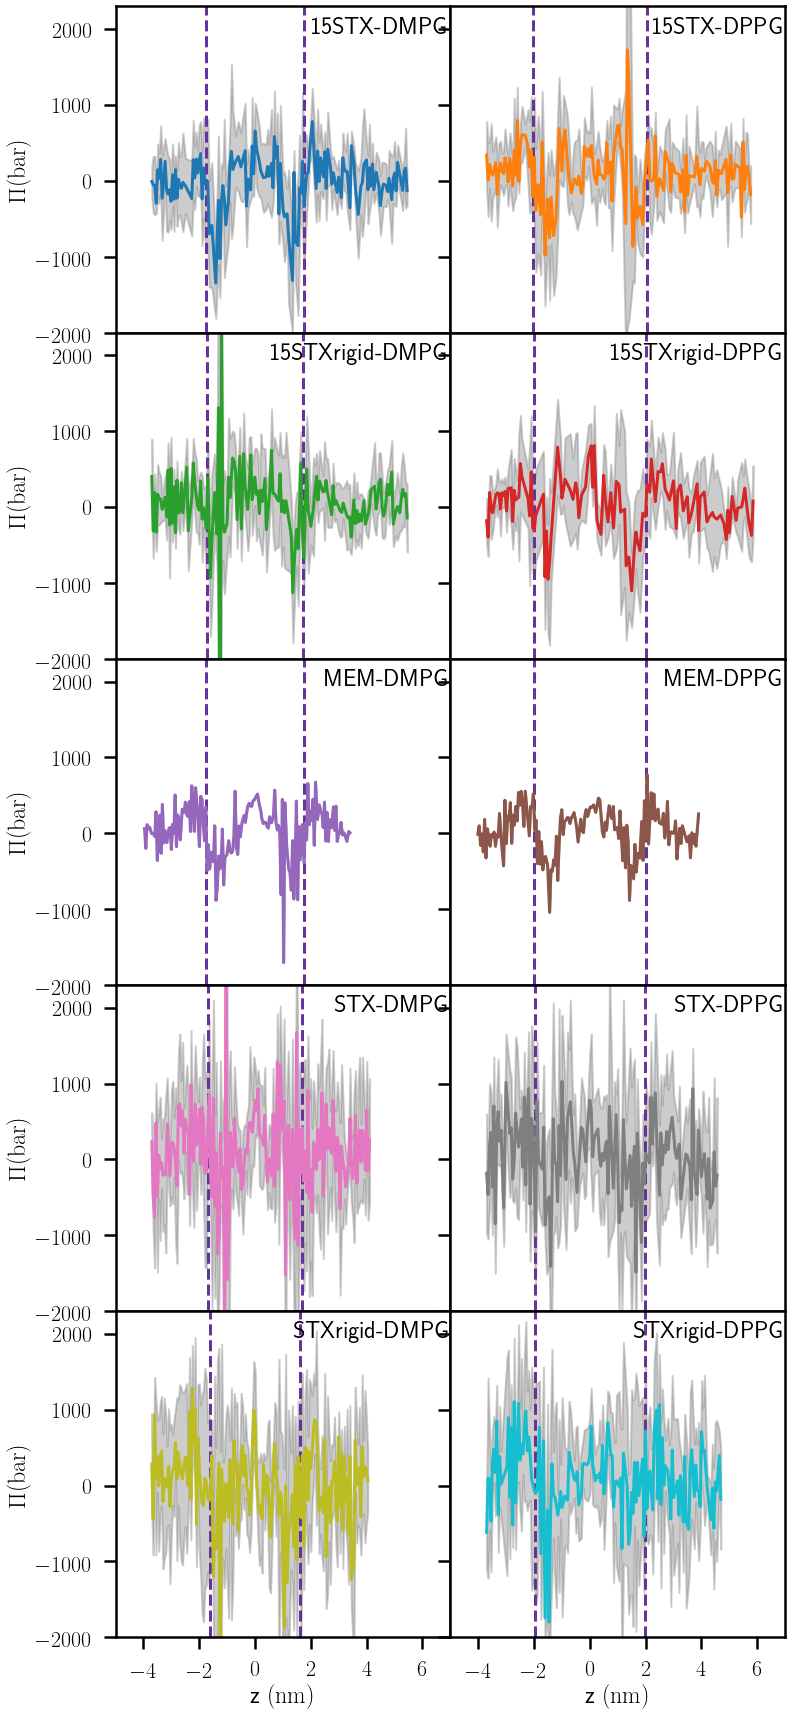

In [16]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=True,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(N):
    for j in range(M):
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in Sim_Direc[cnt]):
                z_com=3.96152
            elif("DPPG" in Sim_Direc[cnt]):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7
#         if(not "MEM" in Sim_Direc[cnt]):
        z,stress=sort("mdstress/stress.txt",Sim_Direc[cnt],2,2,0.05)
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')
                #ax[k][j].scatter(z,-stress[:,4],color=col[cnt])
        e_z=[]
        e_pi=[]
        for k in range(len(z[:,0])):
            e_z.append(2*np.std(z[k,:])/np.sqrt(N))
            e_pi.append(2*np.std(pi(stress)[k,:])/np.sqrt(N))
        ax[i][j].plot(av(z-z_com),av(pi(stress)),color=col[cnt]) #,xerr=e_z,yerr=e_pi
        ax[i][j].fill_between(av(z-z_com), av(pi(stress))-e_pi, av(pi(stress))+e_pi,color="gray",alpha=0.4)
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
#         else:
            
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
#         if(cnt<2):
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        ax[i][j].set_ylim(-2000.,2300)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
        cnt+=1
    #plt.savefig("../Plots/{}_stress_profile.png".format(Sim_Direc[i]))
plt.savefig("../Plots/stress_profile.png")

## Stress profile applying gaussian filtering of 2 sd

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


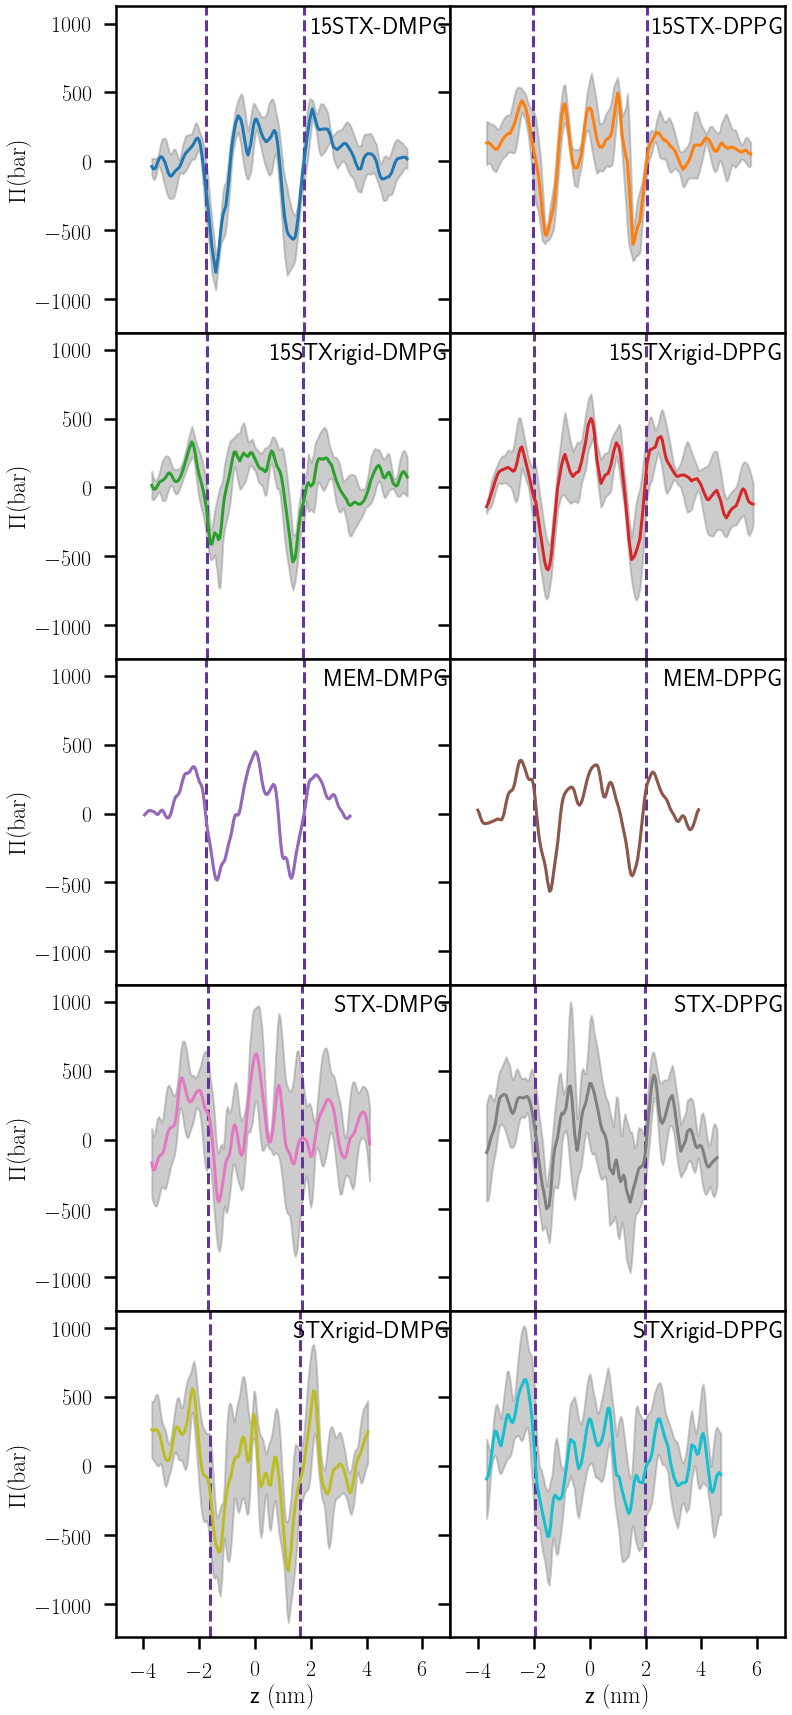

In [17]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=True,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(N):
    for j in range(M):
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in Sim_Direc[cnt]):
                z_com=3.96152
            elif("DPPG" in Sim_Direc[cnt]):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7

#         if(not "MEM" in Sim_Direc[cnt]):
        z,stress=sort("mdstress/stress_2.txt",Sim_Direc[cnt],2,2,0.05)
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')
        #ax[k][j].scatter(z,-stress[:,4],color=col[cnt])
        e_z=[]
        e_pi=[]
        for k in range(len(z[:,0])):
            e_z.append(2*np.std(z[k,:])/np.sqrt(N))
            e_pi.append(2*np.std(pi(stress)[k,:])/np.sqrt(N))
        ax[i][j].plot(av(z-z_com),av(pi(stress)),color=col[cnt]) #,xerr=e_z,yerr=e_pi
        ax[i][j].fill_between(av(z-z_com), av(pi(stress))-e_pi, av(pi(stress))+e_pi,color="gray",alpha=0.4)
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
#         else:
            
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
#         if(cnt<2):
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        #ax[i][j].set_ylim(-2000.,2000)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
        cnt+=1

    #plt.savefig("../Plots/{}_stress_profile.png".format(Sim_Direc[i]))
plt.savefig("../Plots/stress_profile_2.png")

# ## Stress profile applying gaussian filtering of 3 sd

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


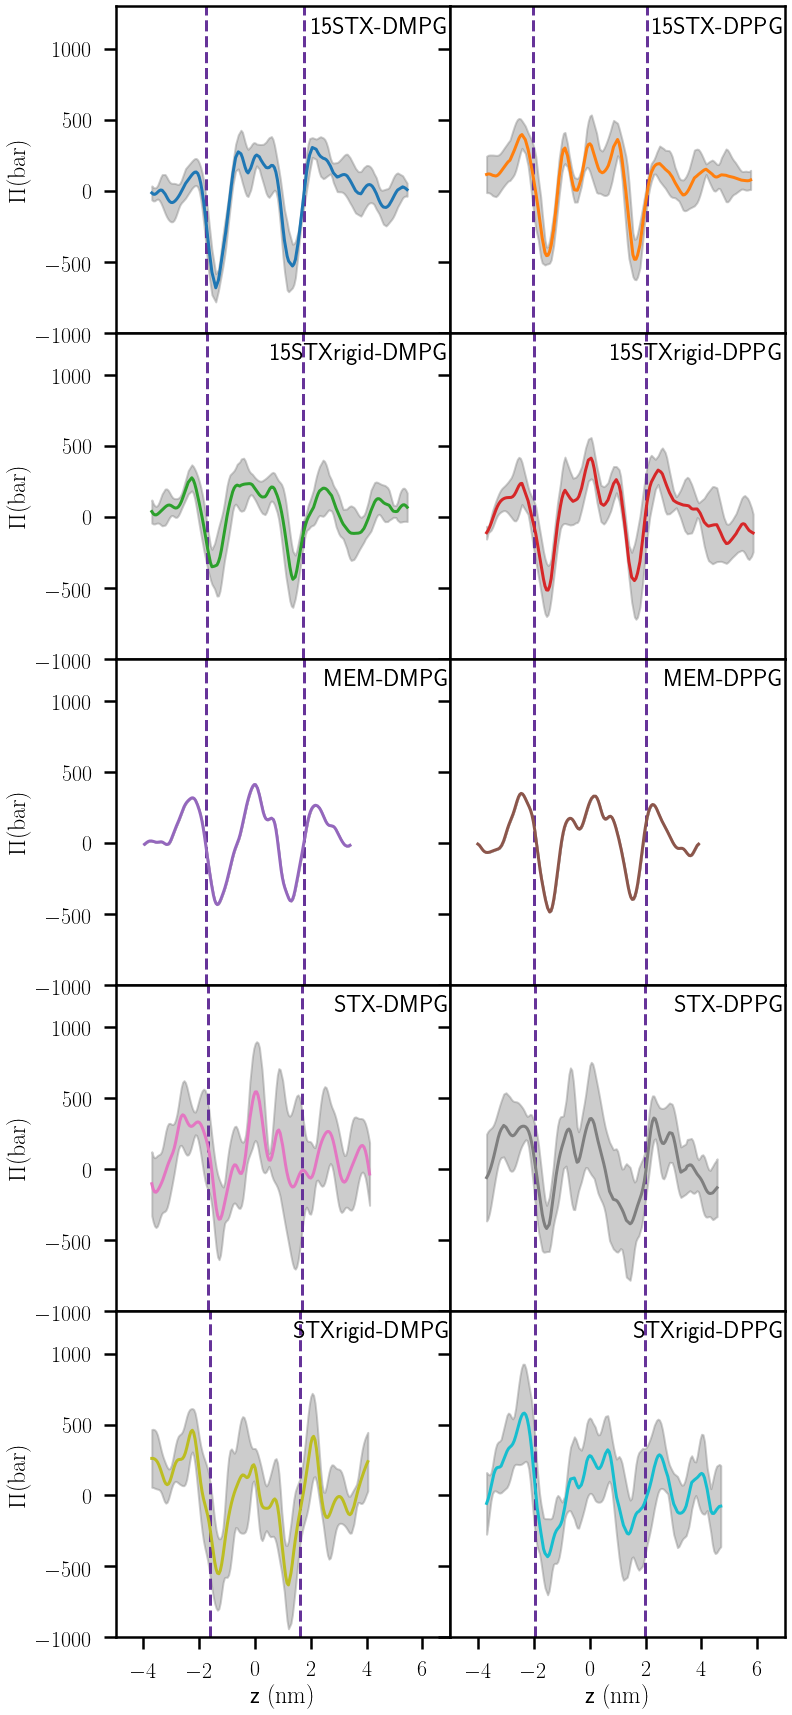

In [18]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=True,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(N):
    for j in range(M):
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in Sim_Direc[cnt]):
                z_com=3.96152
            elif("DPPG" in Sim_Direc[cnt]):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7
        z,stress=sort("mdstress/stress_3.txt",Sim_Direc[cnt],2,2,0.05)
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')

                #ax[k][j].scatter(z,-stress[:,4],color=col[cnt])
        e_z=[]
        e_pi=[]
        for k in range(len(z[:,0])):
            e_z.append(2*np.std(z[k,:])/np.sqrt(N))
            e_pi.append(2*np.std(pi(stress)[k,:])/np.sqrt(N))
        ax[i][j].plot(av(z-z_com),av(pi(stress)),color=col[cnt]) #,xerr=e_z,yerr=e_pi
        ax[i][j].fill_between(av(z-z_com), av(pi(stress))-e_pi, av(pi(stress))+e_pi,color="gray",alpha=0.4)
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
#         else:      
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
#         if(cnt<2):
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        ax[i][j].set_ylim(-1000.,1300)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
        cnt+=1
    #plt.savefig("../Plots/{}_stress_profile.png".format(Sim_Direc[i]))
plt.savefig("../Plots/stress_profile_3.png")

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


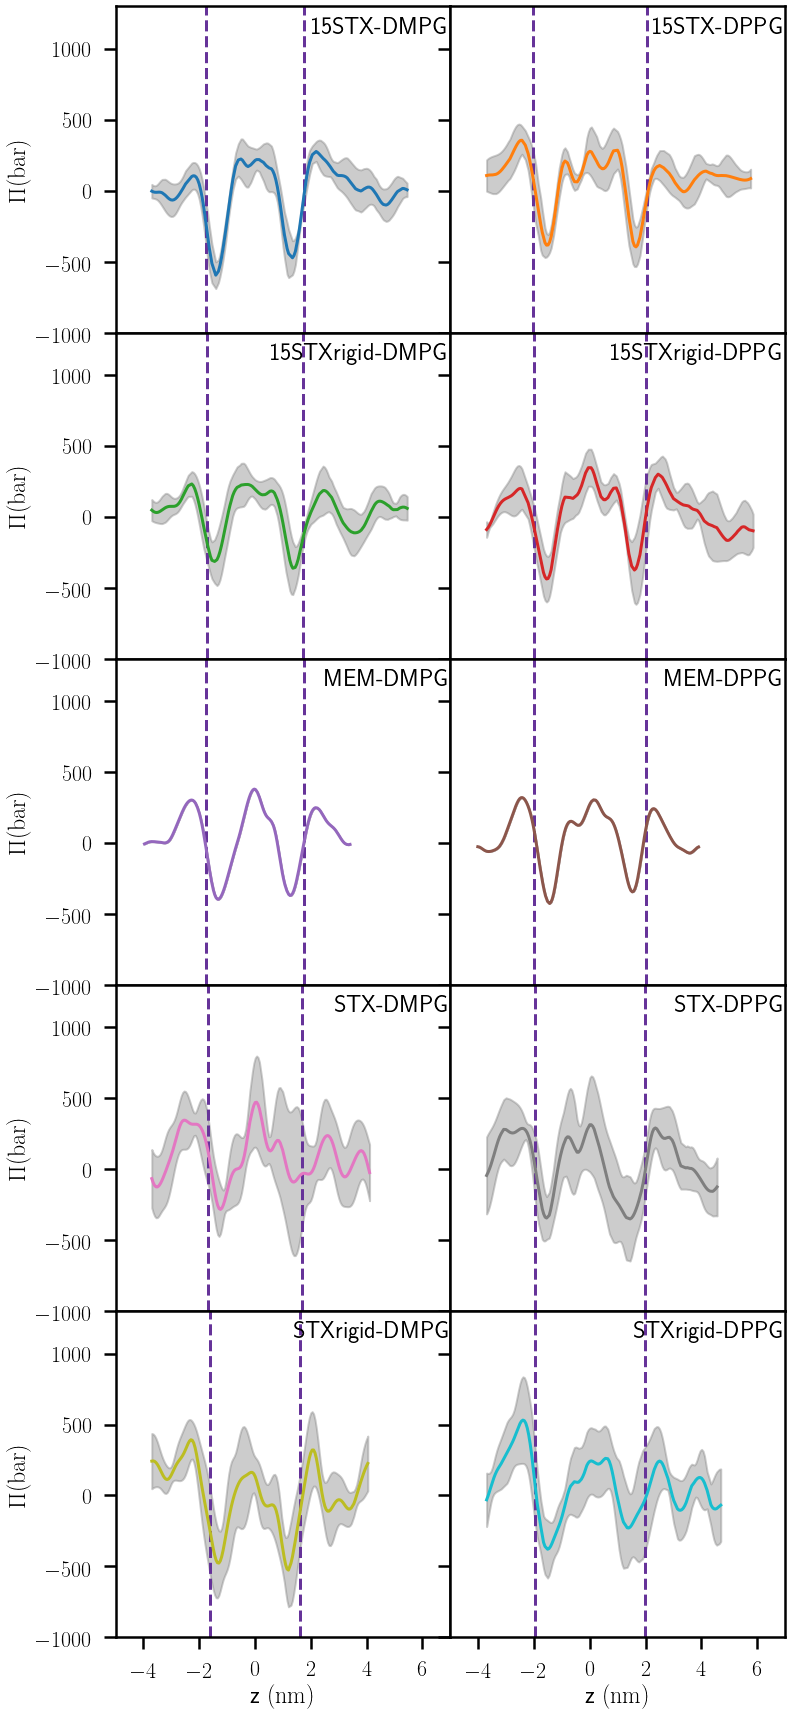

In [19]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=True,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(N):
    for j in range(M):
#         if(not "MEM" in Sim_Direc[cnt]):
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in Sim_Direc[cnt]):
                z_com=3.96152
            elif("DPPG" in Sim_Direc[cnt]):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7
        z,stress=sort("mdstress/stress_4.txt",Sim_Direc[cnt],2,2,0.05)
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')

                #ax[k][j].scatter(z,-stress[:,4],color=col[cnt])
        e_z=[]
        e_pi=[]
        for k in range(len(z[:,0])):
            e_z.append(2*np.std(z[k,:])/np.sqrt(N))
            e_pi.append(2*np.std(pi(stress)[k,:])/np.sqrt(N))
        ax[i][j].plot(av(z-z_com),av(pi(stress)),color=col[cnt]) #,xerr=e_z,yerr=e_pi
        ax[i][j].fill_between(av(z-z_com), av(pi(stress))-e_pi, av(pi(stress))+e_pi,color="gray",alpha=0.4)
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
#         else:
            
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
#         if(cnt<2):
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        ax[i][j].set_ylim(-1000.,1300)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
        cnt+=1
    #plt.savefig("../Plots/{}_stress_profile.png".format(Sim_Direc[i]))
plt.savefig("../Plots/stress_profile_4.png")

# Simmetrization and manual filtering

In [20]:
def sym(file,direc,replica,z_com,sk_l1):
        work_dir = "{}/{}/{}".format(bas_dir[0],direc,replica)
        data = np.genfromtxt("{}/{}".format(work_dir,file),skip_header=sk_l1)
        z=data[:,0]
        stress=data[:,1:]
        z_inf=[]
        stress_inf=[]
        stress_inf2=[]
        z_sup=[]
        z_inf2=[]
        z_f=[]
        s_f=[]
        z_f2=[]
        s_f2=[]
        stress_sup=[]
        z-=z_com
        for i in range(len(z)):
            if(z[i]<0):
                z_inf.append(z[i])
                stress_inf.append(stress[i,:])
            else:
                z_sup.append(z[i])
                stress_sup.append(stress[i,:])
        for i in range(len(z_inf)):
            z_inf2.append(z_inf[len(z_inf)-1-i])
            stress_inf2.append(stress_inf[len(z_inf)-1-i][:])
        if(len(z_inf)<len(z_sup)):
            m=len(z_inf)
            M=len(z_sup)
            for i in range(int(m+(M-m)/2)):#len(z_inf)+(len(z_sup)-len(z_inf))/2
                if(i<m):
                    s_f.append((stress_inf2[i][:]+stress_sup[i][:])/2)
                    z_f.append((-z_inf2[i]+z_sup[i])/2)
                else:
                    z_f.append(z_sup[i])
                    s_f.append(stress_sup[i])
        else:
            m=len(z_sup)
            M=len(z_inf)
            for i in range(int(m+(M-m)/2)):#len(z_sup)+(len(z_inf)-len(z_sup))/2
                if(i<m):
#                    print("a")#stress_inf[i,:])
                    s_f.append((stress_inf2[i][:]+stress_sup[i][:])/2)
                    z_f.append((-z_inf2[i]+z_sup[i])/2)
                else:
                    z_f.append(-z_inf2[i])
                    s_f.append(stress_inf2[i])
        for i in range(len(z_f)):
            z_f2=np.append(z_f2,-z_f[len(z_f)-1-i])
            s_f2=np.append(s_f2,s_f[len(z_f)-1-i][:])
#         print(np.shape(s_f[len(z_f)-1-i][:]))
        z_f2=np.append(z_f2,z_f)
        s_f2=np.append(s_f2,s_f)
        #print(np.shape(z_f2),np.shape(s_f2))
        return z_f2,s_f2.reshape(int(len(s_f2)/9),9)

In [21]:
def sym2(file,direc,replica,z_com,sk_l1):
        work_dir = "{}/{}/{}".format(bas_dir[0],direc,replica)
        data = np.genfromtxt("{}/{}".format(work_dir,file),skip_header=sk_l1)
        z=data[:,0]
        stress=data[:,1:]
        z_inf=[]
        stress_inf=[]
        stress_inf2=[]
        z_sup=[]
        z_inf2=[]
        z_f=[]
        s_f=[]
        z_f2=[]
        s_f2=[]
        stress_sup=[]
        z-=z_com
        for i in range(len(z)):
            if(z[i]<0):
                z_inf.append(z[i])
                stress_inf.append(stress[i,:])
            else:
                z_sup.append(z[i])
                stress_sup.append(stress[i,:])
        for i in range(len(z_inf)):
            z_inf2.append(z_inf[len(z_inf)-1-i])
            stress_inf2.append(stress_inf[len(z_inf)-1-i][:])
        if(len(z_inf)<len(z_sup)):
            m=len(z_inf)
            M=len(z_sup)
            for i in range(int(m+(M-m)/2)):#len(z_inf)+(len(z_sup)-len(z_inf))/2
                if(i<m):
                    s_f.append((stress_inf2[i][:]+stress_sup[i][:])/2)
                    z_f.append((-z_inf2[i]+z_sup[i])/2)
                else:
                    z_f.append(z_sup[i])
                    s_f.append(stress_sup[i])
        else:
            m=len(z_sup)
            M=len(z_inf)
            for i in range(int(m+(M-m)/2)):#len(z_sup)+(len(z_inf)-len(z_sup))/2
                if(i<m):
#                    print("a")#stress_inf[i,:])
                    s_f.append((stress_inf2[i][:]+stress_sup[i][:])/2)
                    z_f.append((-z_inf2[i]+z_sup[i])/2)
                else:
                    z_f.append(-z_inf2[i])
                    s_f.append(stress_inf2[i])
        for i in range(len(z_f)):
            z_f2=np.append(z_f2,-z_f[len(z_f)-1-i])
            s_f2=np.append(s_f2,s_f[len(z_f)-1-i][:])
#         print(np.shape(s_f[len(z_f)-1-i][:]))
        z_f2=np.append(z_f2,z_f)
        s_f2=np.append(s_f2,s_f)
        #print(np.shape(z_f2),np.shape(s_f2))
        return z_f2,s_f2.reshape(int(len(s_f2)/9),9)

In [22]:
def pi_s(stress):
    pxx=-stress[:,0]
    pyy=-stress[:,4]
    pzz=-stress[:,8]
    return (pxx+pyy)/2-pzz

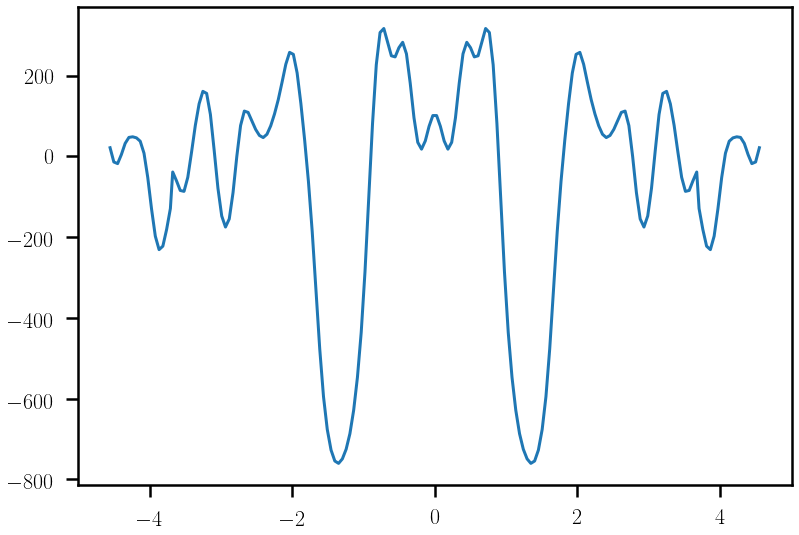

In [23]:
z,stress=sym2("mdstress/stress_2.txt",Sim_Direc[0],1,3.7,2)
plt.plot((z),(pi_s(stress)),color=col[0])
#np.shape(stress)

In [24]:
titles="z	Sxx	Sxy	Sxz	Syx	Syy	Syz	Szx	Szy	Szz"
#titles=["z","Sxx","Sxy","Sxz","Syx","Syy","Syz","Szx","Szy","Szz"]

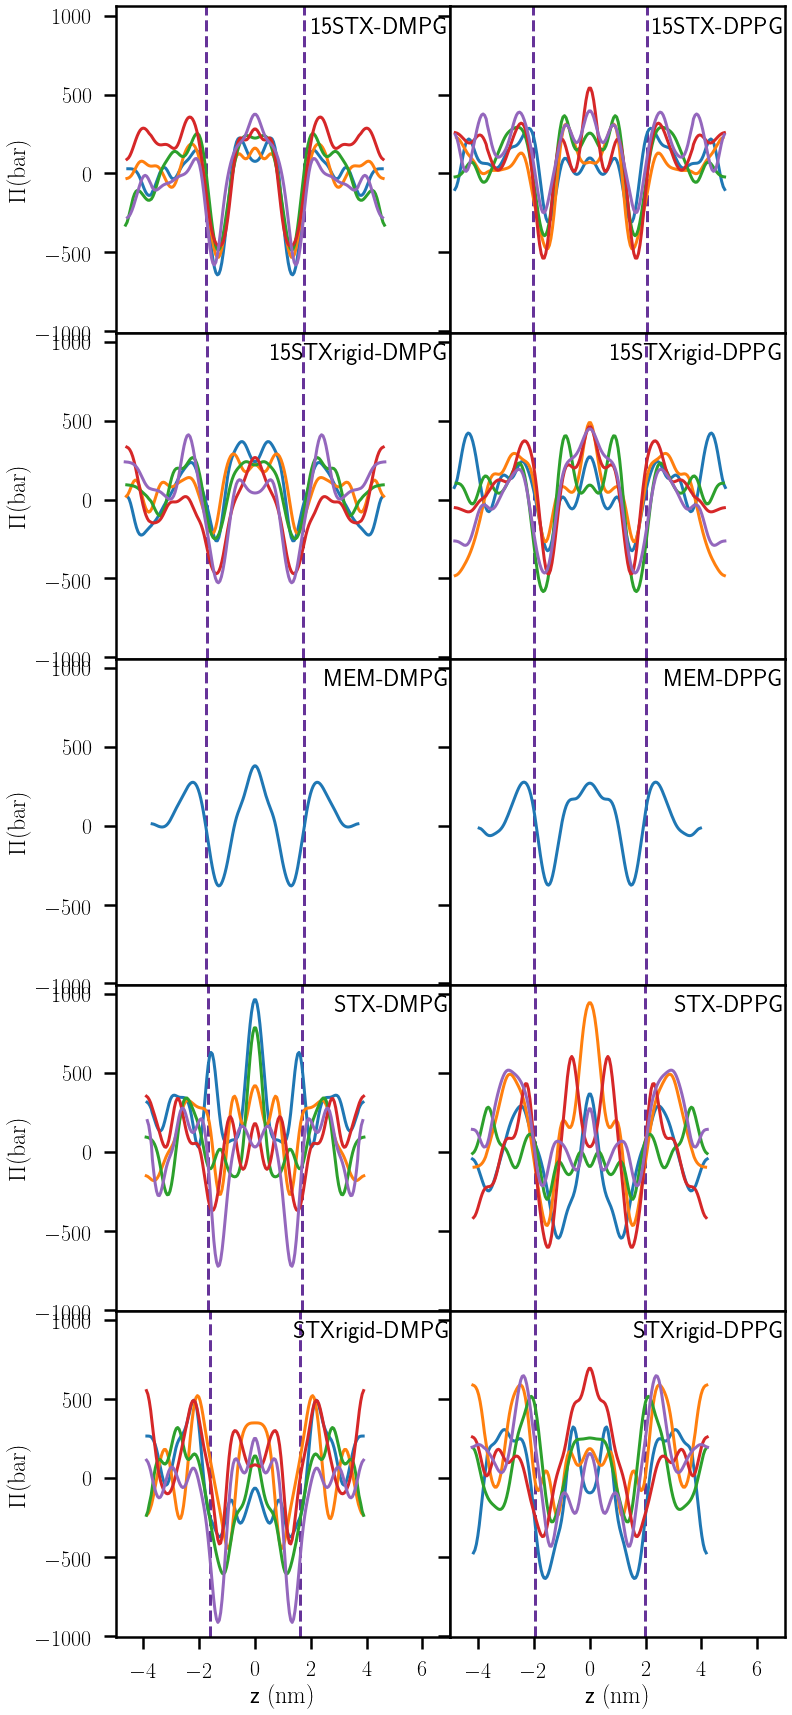

In [25]:
cnt=0
N1=5
M=2
fig,ax  = plt.subplots(N,M,sharex=True,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(N1):
    for j in range(M):
#########################        
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in Sim_Direc[cnt]):
                z_com=3.96152
            elif("DPPG" in Sim_Direc[cnt]):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7
########################
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')
#         z_d,sigma_d=sort("mdstress/stress.txt",Sim_Direc[l],2,2)#stress,z=f("mdstress/stress.txt",Sim_Direc[4],2,2)
#         plt.plot(z_d[:,0],pi(sigma_d[:,:,:])[:,0],label="no filter or")
        work_dir = ("{}/{}".format(Sim_Direc[cnt],replica))
        for replica in range(start,N+1):
            z,stress=sym("mdstress/stress.txt",Sim_Direc[cnt],replica,z_com,2)
            #ax[i][j].plot(z[:],pi_s(np.array(stress)),label="no filter")
            f=[]
            #print(np.shape(stress))#[:,:,0])
#             print(np.shape(np.array(stress)[:,0]))
            for k in range(len(stress[0][:])): #10
                f.append( gaussian_filter(np.array(stress)[:,k],4 , mode='wrap', truncate = 4, order = 0))
            g_filter=np.transpose(f)
            table=np.zeros((len(z),len(g_filter[0,:])+1))
            for l in range(len(z)):
                table[l,0]=z[l]
                for m in range(1,len(g_filter[0][:])+1):
                    table[l,m]=g_filter[l][m-1]
            np.savetxt("{}/{}/{}/mdstress/stress_filtered.txt".format(bas_dir[0],Sim_Direc[cnt],replica),table,header=titles)
            ax[i][j].plot(z[:],pi_s(g_filter),label="manual filter")
#             z_2,sigma_2=sort("mdstress/stress_2.txt",Sim_Direc[j],2,2)
#             ax[i][j].scatter(z_2[:],pi(sigma_2),label="filter 2sd")
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
#         else:
            
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
#         if(cnt<2):
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
        cnt+=1
#     #plt.savefig("../Plots/{}_stress_profile.png".format(Sim_Direc[i]))
# plt.savefig("../Plots/stress_profile.png")

(135, 5) 	 (135, 5, 10)
(134, 5) 	 (134, 5, 10)
(144, 5) 	 (144, 5, 10)
(113, 5) 	 (113, 5, 10)
(148, 1) 	 (148, 1, 10)
(158, 1) 	 (158, 1, 10)
(151, 5) 	 (151, 5, 10)
(137, 5) 	 (137, 5, 10)
(151, 5) 	 (151, 5, 10)
(136, 5) 	 (136, 5, 10)


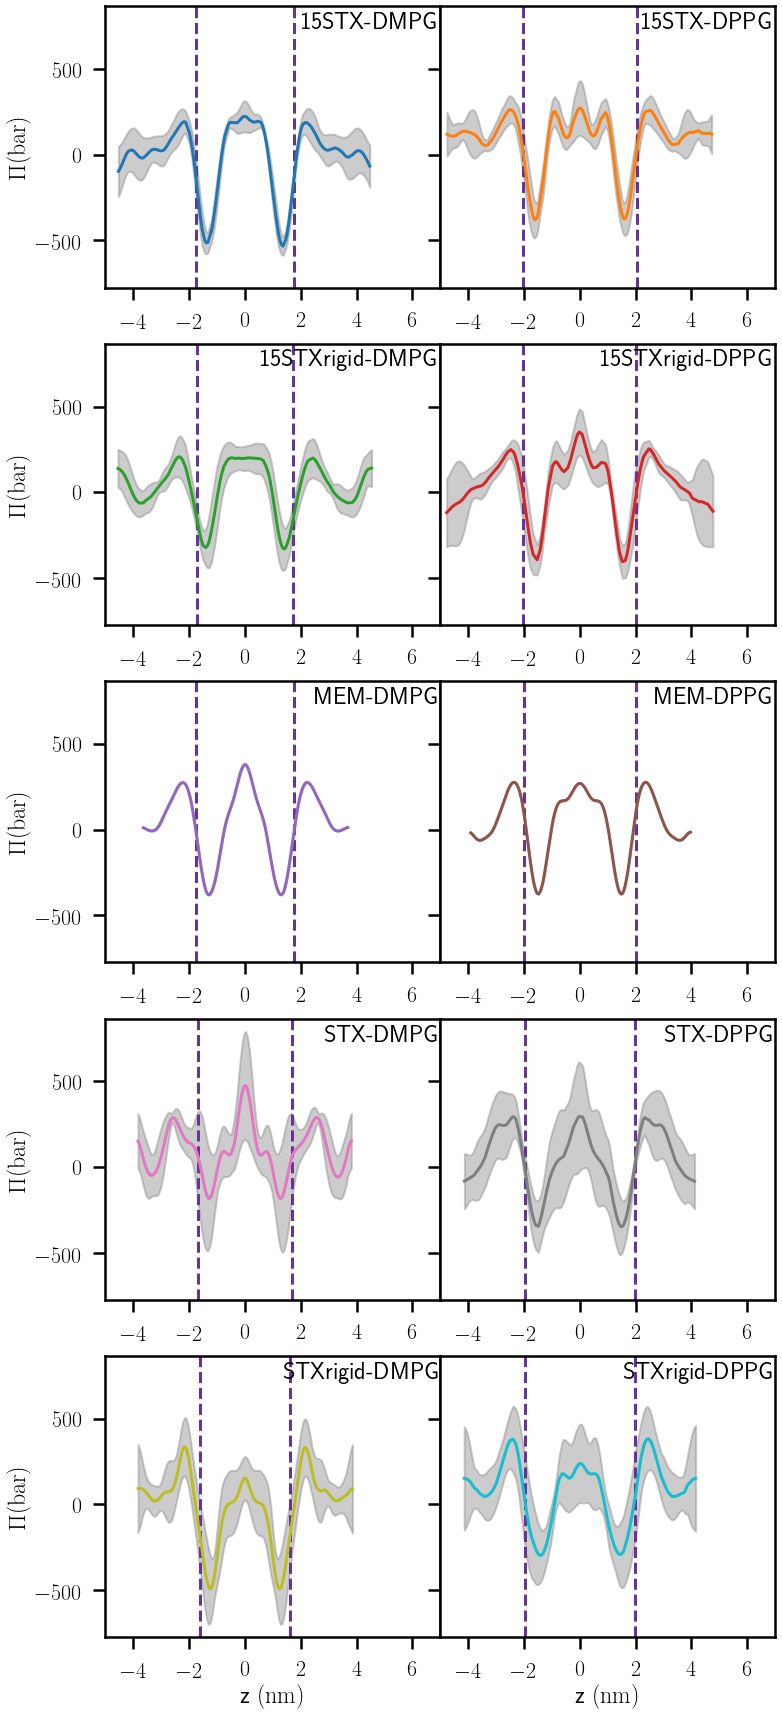

In [26]:
cnt=0
N1=5
M=2
fig,ax  = plt.subplots(N1,M,sharex=False,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0.2, 'wspace': 0})
for i in range(N1):
    for j in range(M):
        work_dir = ("{}/{}".format(Sim_Direc[cnt],1))
        z,stress=sort("mdstress/stress_filtered.txt",Sim_Direc[cnt],2,2,0.05)
        #z_p,p_dens=sort("density/p_density.xvg",Sim_Direc[cnt],0,0,0.15)
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')
#         print(np.shape(z_d),np.shape(av(np.array(sigma_d))))
        e_z=[]
        e_pi=[]
        for k in range(len(z[:,0])):
            e_z.append(2*np.std(z[k,:])/np.sqrt(N))
            e_pi.append(2*np.std(pi(stress)[k,:])/np.sqrt(N))
        ax[i][j].plot(av(z),av(pi(stress)),color=col[cnt]) #,xerr=e_z,yerr=e_pi
        ax[i][j].fill_between(av(z), av(pi(stress))-e_pi, av(pi(stress))+e_pi,color="gray",alpha=0.4)
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
#         else:
            
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
#         if(cnt<2):
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        #ax[i][j].set_ylim(-2000.,2000)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
############
        cnt+=1
plt.savefig("../Plots/stress_profile_2_sym.png")

In [27]:
for i in range(len(z)):
    print((z[0,:]))
#         if(np.abs(z[0,0]-min(z[0,:]))/0.05>1):
#             print(np.abs(z[0,0]-min(z[0,:]))/0.05)
# print(len(z))

[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.11874156 -4.14070436 -4.12362397 -4.15582461 -4.16867078]
[-4.1187

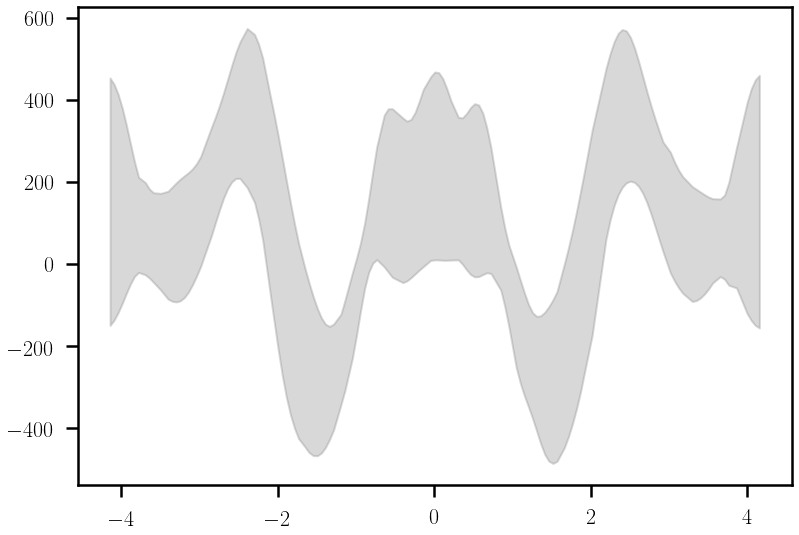

In [28]:
# (-4.16867078+4.11874156)
plt.fill_between(av(z), av(pi(stress))-e_pi, av(pi(stress))+e_pi,color="gray",alpha=0.3)
# print(z)

## Example

(136, 5) 	 (136, 5, 10)
(136, 5, 10)
(9, 136)
(136, 1, 9)
(136, 5) 	 (136, 5, 10)


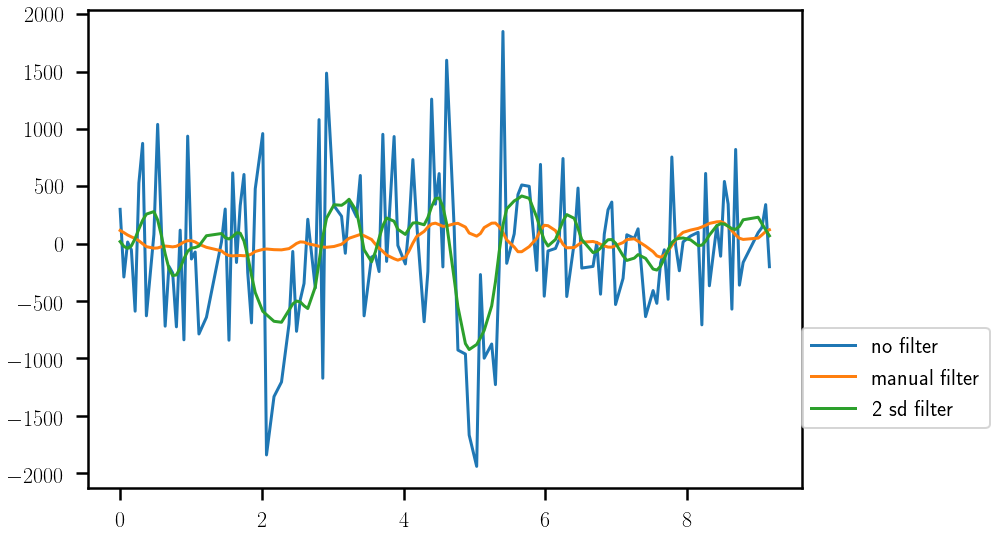

In [29]:
        l=0
        work_dir = ("{}/{}".format(Sim_Direc[l],1))
        z_d,sigma_d=sort("mdstress/stress.txt",Sim_Direc[l],2,2,0.05)#stress,z=f("mdstress/stress.txt",Sim_Direc[4],2,2)
        plt.plot(z_d[:,0],pi(sigma_d[:,:,:])[:,0],label="no filter")
        f=[]
        print(np.shape(sigma_d))#[:,:,0]))
        for i in range(1):#len(sigma_d[0,:,0])): #5
            for j in range(1,len(sigma_d[0,0,:])): #10
                f.append(gaussian_filter(sigma_d[:,i,j], 2, mode='wrap', truncate = 4, order = 0))
        print(np.shape((f)))
        g_filter=np.reshape(np.transpose(f),[np.shape(sigma_d)[0],1,9])
        #g_filter=np.transpose(f)
        #plt.plot(z_d[:,0],pi_s(g_filter),label="manual filter")
        plt.plot(z_d[:,0],pi(g_filter)[:,0],label="manual filter")
        print(np.shape(g_filter))
        # z,sigma=sort("mdstress/stress.txt",Sim_Direc[l],2,2)#stress,z=f("mdstress/stress.txt",Sim_Direc[4],2,2)
        # plt.plot(z[:,0],pi(sigma[:,:,:])[:,0],label="no filter")
        z,sigma=sort("mdstress/stress_2.txt",Sim_Direc[l],2,2,0.05)#stress,z=f("mdstress/stress.txt",Sim_Direc[4],2,2)
        plt.plot(z[:,0],pi(sigma[:,:,:])[:,0],label="2 sd filter")
        plt.legend(loc=(1,.5/4))

# Stress matrix

	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz
	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz


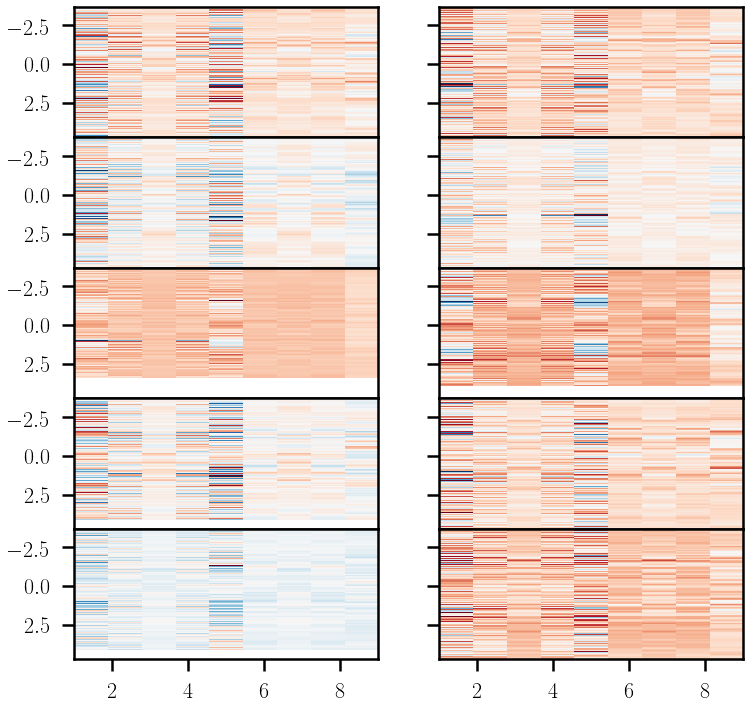

In [30]:
cnt=0
N1=5
M=2
fig,ax  = plt.subplots(N1,M,sharex=True,sharey=True,figsize=(12,12),gridspec_kw={'hspace': 0, 'wspace': 0.2})
for i in range(N1):
    for j in range(M):
#########################        
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in Sim_Direc[cnt]):
                z_com=3.96152
            elif("DPPG" in Sim_Direc[cnt]):
                z_com=4.01457
        else:
            start=2;
            N=3#5
            z_com=3.7
########################
#         z_d,sigma_d=sort("mdstress/stress.txt",Sim_Direc[l],2,2)#stress,z=f("mdstress/stress.txt",Sim_Direc[4],2,2)
#         plt.plot(z_d[:,0],pi(sigma_d[:,:,:])[:,0],label="no filter or")
        for replica in range(start,N+1):            
            work_dir = ("{}/{}".format(Sim_Direc[cnt],replica))
            data = np.genfromtxt("{}/{}/mdstress/stress.txt".format(bas_dir[0],work_dir),skip_header=2)
            mini=np.min(data[:,1:])
            maxi=np.max(data[:,1:])
            ax[i][j].imshow(data[:,1:],cmap=plt.cm.RdBu, aspect="auto", extent=[1,9,data[-1,0]-z_com,data[0,0]-z_com])
            #fig.colorbar(y,boundaries=np.arange(mini,maxi,500)).set_ticks(np.arange(mini,maxi,500))
            print("\t pxx\t pxy\t pxz\t pyx\t pyy\t pyz\t pzx\t pzy\t pzz")
        cnt+=1
#     #plt.savefig("../Plots/{}_stress_profile.png".format(Sim_Direc[i]))
# plt.savefig("../Plots/stress_profile.png")

	 pxx	 pxy	 pxz	 pyx	 pyy	 pyz	 pzx	 pzy	 pzz


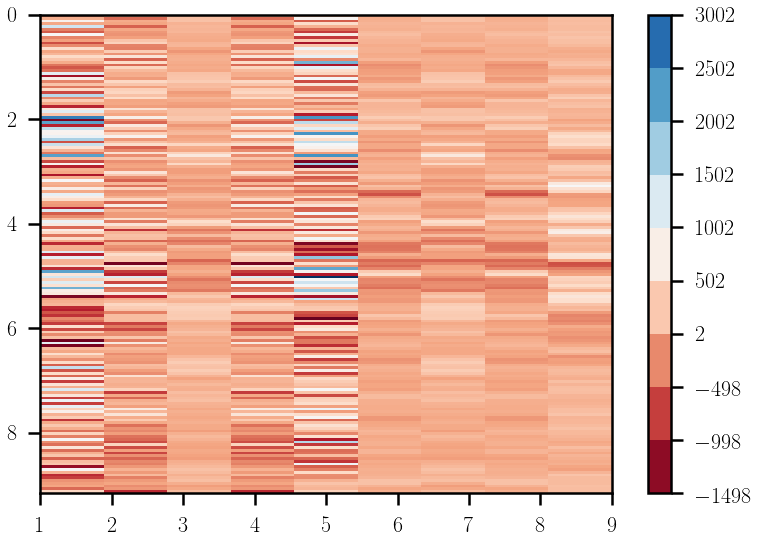

In [31]:
work_dir = ("{}/{}".format(Sim_Direc[0],1))
data = np.genfromtxt("{}/{}/mdstress/stress.txt".format(bas_dir[0],work_dir),skip_header=2)
mini=np.min(data[:,1:])
maxi=np.max(data[:,1:])
plt.imshow(data[:,1:],cmap=plt.cm.RdBu, aspect="auto", extent=[1,9,data[-1,0],data[0,0]])
plt.colorbar(boundaries=np.arange(mini,maxi,500)).set_ticks(np.arange(mini,maxi,500))
print("\t pxx\t pxy\t pxz\t pyx\t pyy\t pyz\t pzx\t pzy\t pzz")

In [32]:
# minimum=0.45
# maximum=0.9
# file="apl"
# x_best=[[],[]]
# col2={"MEM":'tab:blue',"STX-":'tab:orange',"STXrigid":'tab:green',"15STX":'tab:red'}#,"MEMplugin"'tab:purple'}
# lab=["MEM","STX-","STXrigid","15STX"]#,"MEMplugin"]
# fig,ax  = plt.subplots(2,2,sharex=True,sharey=False,figsize=(16,5),gridspec_kw={'hspace':0.2, 'wspace': 0.2})
#     #ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
# for cnt in range(len(Sim_Direc)):
#     if("MEM" in Sim_Direc[cnt]):
#         start=1;
#         N=1
#     else:
#         start=1;
#         N=5
#     z,stress=sort("mdstress/stress_filtered.txt",Sim_Direc[cnt],2,2,0.05)
#     for s in range(2):
#         x_bar=np.mean(data[s])
#         uncer=1.96*np.std(data[s])/np.sqrt(5)
#         x_best[0].append(x_bar)
#         x_best[1].append(uncer)
#                 #print(x_bar)
#     for q in range(len(lab)):
#         if(lab[q] in Sim_Direc[cnt]):
#             pos=q
#                 #ax[0][0].set_title("DPPG")
#                 #ax[0][1].set_title("DMPG")
#     if("DPPG" in Sim_Direc[cnt]):
#         ax[0][0].set_ylabel(r" Matrix \\ glomepro")
#         ax[1][0].set_ylabel(r"Avg lipid \\ glomepro")
#         for s in range(2):
#             ax[s][0].hist(data[s],bins=50,range=[minimum,maximum],density=True,color=col2[lab[pos]],histtype="step")
#             ax[s][0].axvline(0.67,linestyle="-",color='rebeccapurple')
#                         #ax[s][0].set_ylabel(r"Frequency (\%)")
#             if(s==1):
#                 ax[s][0].set_xlabel(r" APL $\displaystyle (n\mathrm{m}^2)$")
#             ax[s][0].set_xlim(minimum,maximum-0.15)
#             ax[s][0].set_xticks(np.arange(minimum,maximum-0.15+delta,delta))#np.arange(minimum+delta
#             ax[s][0].set_yticks([0,25,50,75])
#             ax[s][0].yaxis.set_tick_params(labelsize=20)
#             plt.setp(ax[s][0].get_xticklabels(), rotation=60, horizontalalignment='right')
#     else:
#         for s in range(2):
#             ax[s][1].hist(data[s],bins=50,range=[minimum,maximum],density=True,color=col2[lab[pos]],histtype="step")
#             ax[s][1].axvline(0.684,linestyle="-",color='rebeccapurple')
#             if(s==1):
#                 ax[s][1].set_xlabel(r" APL $\displaystyle (n\mathrm{m}^2)$")
#             ax[s][1].set_xlim(minimum,maximum-0.17)
#             ax[s][1].set_xticks(np.arange(minimum,maximum-0.15+delta,delta))
#             ax[s][1].set_yticks([0,25,50,75])
#             ax[s][1].yaxis.set_tick_params(labelsize=20)
#             plt.setp(ax[s][1].get_xticklabels(), rotation=60, horizontalalignment='right')

In [33]:
np.min(data[:,1:])

-1498.233300410083